## 1. Introducing Metric Learning
To start experimenting with Metric Learning we start with a simple example, on a simple dataset.

For this first examples we use MNIST dataset, which allow us to train and test on the Colab GPU in realtime.



In [ ]:
# just redo some import to be sure
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
# make sure you have some hardware to run this on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


Now we define our simple network. We are going to use contrastive learning, but the network is not effected by this. The network is a simple single branch convolutional neural network that produces an embedding from an image.

In particular, we want our embedding size to be 128. We then design our network to take as input the image and perform a series on convolutions (this is the *conv(x)* function). After the convolutions we need to reshape our data to get a properly shaped embedding vector. First we reshape the data from a tensor of shape (64,7,7) to a flattened one of shape (64*7*7). We follow this with two linear blocks to get the final 128 features of the desired embedding.

In [ ]:
# Define the Siamese Network
class MetricCNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super(MetricCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)  # L2 normalization

We can visualize our network

In [ ]:
from torchsummary import summary
model = MetricCNN(embedding_dim=128).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
Total params: 436,864
Trainable params: 436,864
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.67
Estimated Total Size (MB): 2.32
-------------------------------------------

Then we prepare our dataset. We download it again, but it shouldn't take too long.

Since we are using contrastive learning we need to fatch couple of images, therefore we have a custom *getitem* function. First we retrieve an image at position *index*, next we randomply select an image that can be either in the same class or in adifferent class. This gives us a list of possible indeces, we take one randomply from this list. Finally we compute the label, 1 if the images belongs to the same class, 0 otherwise, and return the two images, this label, and the original label of the image

In [ ]:
# Create a Custom Dataset for Siamese Training (Pairs of Images)
class SiameseMNISTDataset(Dataset):
    def __init__(self, train=True):
        transform = transforms.Compose([transforms.ToTensor()])
        self.dataset = MNIST(root="./data", train=train, transform=transform, download=True)
        self.data = self.dataset.data
        self.targets = self.dataset.targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Pick the first image
        img1, label1 = self.data[index], self.targets[index]

        # Decide whether to make a positive or negative pair
        if random.random() < 0.5:
            indices = np.where(self.targets == label1)[0]
        else:
            indices = np.where(self.targets != label1)[0]

        index2 = np.random.choice(indices)
        img2, _ = self.data[index2], self.targets[index2]

        # Convert to float tensors
        img1 = img1.unsqueeze(0).float() / 255.0
        img2 = img2.unsqueeze(0).float() / 255.0

        # Create binary label: 1 for similar, 0 for dissimilar
        sim_label = torch.tensor(int(label1 == self.targets[index2]), dtype=torch.float32)

        # Also return the actual digit label of the first image for visualization
        return img1, img2, sim_label, int(label1)


Now wehave to define our contrastive loss

we defin the margin hyperparameter which defines the minimum separation distance for dissimilar pairs.

This means that if two embeddings belong to different classes, their distance should be at least margin to maximize the loss function. If their distance is greater than margin, the loss is 0.

First we compute the distance between the two embeddings. For our example we use the simple euclidean distance, which is *pairwise_distance*, but in different scenarios we could use other distances we saw previously, like manhattan and cosine similarity.

Give the distance we have to compute the loss function. The loss function has to push similar pairs togather and push apart different ones. The loss function is then structured in this two blocks:
- `label*torch.pow(euclidean_distance, 2)` : the first part of the loss, for same class objects. If the label is one the loss encourages value of low euclidean distance to have low loss. If the label is zero, different objects, this element has value zero.
- `(1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)` : the second part of the loss, to push apart different elements. We multiply by 1-label so that it activates for different elements with label 0. We compute the differance between the distance and the margin and we clam it. Meaning, if the distance is a negative value we set it to zero, because the distance is already above margin. Instead if it is positive we have to further push apart the two elements, and we preserve it. Like for the first part we take the square of the value.
- We could have also used different metrics, like cosine similarity, manhattan, etc.:
 - `cos_sim = F.cosine_similarity(output1, output2, dim=1)`
 - `manhattan_distance = torch.sum(torch.abs(output1 - output2), dim=1)`
 - `hamming_distance = torch.sum(output1 != output2, dim=1).float()`





In [ ]:
# Define the Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean(label * torch.pow(euclidean_distance, 2) +  # Push similar pairs together
                          (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))  # Push different pairs apart
        return loss

Now we are ready to train.
We first create the dataloader calling the previously defined functions
Then  we create the network, define the custom loss, and the optimizer. For this simple task we can use Adam.

Next we start the training loop, we iterate through epochs, and for epoch through images. We feed each image of the pair to the network and retrieve the embedding. Then we compute the loss given the two embeddings and the label (same class or different class). Given the loss we then update the model weights and compute the cumulative loss for debug.

In [ ]:
# Train the Siamese Network
def train_siamese(epochs=5, batch_size=64, learning_rate=0.001):
    # Load dataset
    print ("Dataset Loading")
    train_dataset = SiameseMNISTDataset(train=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, loss function, optimizer
    print ("Model Initialization")
    model = MetricCNN(embedding_dim=128).to(device)
    criterion = ContrastiveLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print ("We now start the training process")
    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0
        for img1, img2, label, _ in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            # Forward pass
            output1 = model(img1)
            output2 = model(img2)

            # Compute loss
            loss = criterion(output1, output2, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

    # Save model
    torch.save(model.state_dict(), "siamese_mnist.pth")
    print("Model saved as siamese_mnist.pth")
    return model

As we saw previously the network will learn to push closer images which belongs to the same class and push apart images of different classes inside the embedding. We still require a way to visualize the data outside of the embedding. We can use multiple approaches. For this we still use t-SNE (t-distributed Stochastic Neighbor Embedding)) so we can compare the output with our previous output

We start running our network on single images from the test set, and we save the embedding and the lavel (this time the number from MNIST not the 0/1 values used in training phase). From this pahse we have a vector of embeddings and a vector of classes (labels).

The final step is to run t-SNE to move from the 128 dimensions of the embeding to just a 2D visualization to get an idea on how separate are our data.  

In [ ]:
# Visualize Embeddings Using t-SNE
def visualize_embeddings(model, n_samples=500):
    test_dataset = SiameseMNISTDataset(train=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    embeddings, true_labels = [], []
    model.eval()

    with torch.no_grad():
        for img1, _, _, digit_label in test_loader:
            img1 = img1.to(device)
            embedding = model(img1)
            embeddings.append(embedding.cpu().numpy().flatten())
            true_labels.append(digit_label.item())
            if len(embeddings) >= n_samples:
                break


    # Convert to numpy arrays
    embeddings = np.array(embeddings)
    labels = np.array(true_labels)

    # Apply t-SNE
    from sklearn.manifold import TSNE
    X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(label="Digit Label")
    plt.title("t-SNE Visualization of Learned MNIST Embeddings (Siamese Network)")
    plt.show()

Now it is time to start the whole training process

In [ ]:
model = train_siamese(epochs=5)

Dataset Loading
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.46MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Model Initialization
We now start the training process
Epoch [1/5], Loss: 0.0427
Epoch [2/5], Loss: 0.0142
Epoch [3/5], Loss: 0.0093
Epoch [4/5], Loss: 0.0070
Epoch [5/5], Loss: 0.0060
Model saved as siamese_mnist.pth


Given our model we can now visualize how it performs using t-SNE on the test set

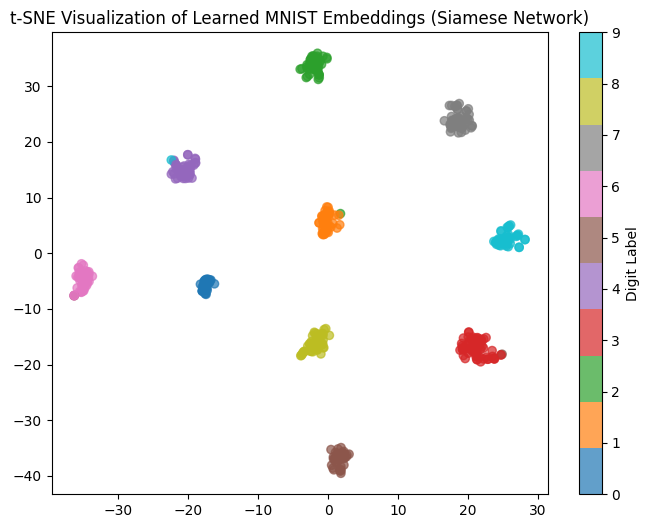

In [ ]:
visualize_embeddings(model)

## 2. Triplet Loss
While contrastive learning works well in simple scenario like MNIST, more complex data could require more advanced setup. Before moving to more complex data we explore the usage of the triplet loss on this simple scenario.

We can keep part of the code we have previously used, and update the data loader, loss function, and training

First we have to restrcucture the data loader. In this scenario we don't have only positive and negative data, but we have three images, a positive, an anchor, and a negative.

Like in the previous example we have a custom getitem function. Furst we get the anchor with its label. Next, like in the previous example, we find all indices with the same label and pick one randomly. We proceed doing the same for the negative. Our function returns these three images, anchor, positive and negative

In [ ]:
class TripletMNISTDataset(Dataset):
    def __init__(self, train=True):
        transform = transforms.Compose([transforms.ToTensor()])
        self.dataset = MNIST(root="./data", train=train, transform=transform, download=True)
        self.data = self.dataset.data
        self.targets = self.dataset.targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Select the anchor image
        anchor, label = self.data[index], self.targets[index]

        # Select a positive sample (same class)
        positive_indices = np.where(self.targets == label)[0]
        positive_index = np.random.choice(positive_indices)
        positive = self.data[positive_index]

        # Select a negative sample (different class)
        negative_indices = np.where(self.targets != label)[0]
        negative_index = np.random.choice(negative_indices)
        negative = self.data[negative_index]

        # Convert images to float tensors
        anchor = anchor.unsqueeze(0).float() / 255.0
        positive = positive.unsqueeze(0).float() / 255.0
        negative = negative.unsqueeze(0).float() / 255.0

        return anchor, positive, negative, int(label)

We also update our loss function, since we have three embedding instead of two to compare. Similarly to the previous example we use the euclidean distance to compute the distance between embeddings, and use a margin of 1.

The loss function is then streightforward, we sum the positive distance, which should go to zero for elements of the same class, we subtract the negative distance, which instead should grow higher for objects of different classes, and we sum the margin to enforce stronger data sepratation.

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)  # Distance between anchor & positive
        neg_dist = F.pairwise_distance(anchor, negative)  # Distance between anchor & negative
        loss = torch.mean(torch.clamp(pos_dist - neg_dist + self.margin, min=0.0))  # Enforce separation
        return loss


Now we write the train function. Similar to the previous example we create our dataset, model and loss. Also in this example we employ the Adam ptimizer. Then we iterate for each epoch and we get from the data loader the three images. For each image we compute the embeddings and computethe loss

In [ ]:
def train_triplet(epochs=5, batch_size=64, learning_rate=0.001):
    print("Dataset Loading")
    train_dataset = TripletMNISTDataset(train=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    print("Model Initialization")
    model = MetricCNN(embedding_dim=128).to(device)
    criterion = TripletLoss(margin=1.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training Process")
    for epoch in range(epochs):
        epoch_loss = 0
        for anchor, positive, negative, _ in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Forward pass
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)

            # Compute loss
            loss = criterion(anchor_emb, positive_emb, negative_emb)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), "triplet_mnist.pth")
    print("Model saved as triplet_mnist.pth")
    return model


Like in the previous example we test the model and visualize the data. Since we use high-dimension embadding we lavarage again t-SNE to convert them o a 2D embedding

In [ ]:
def visualize_triplet_embeddings(model, n_samples=500):
    test_dataset = TripletMNISTDataset(train=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    embeddings, true_labels = [], []
    model.eval()

    with torch.no_grad():
        for anchor, _, _, digit_label in test_loader:
            anchor = anchor.to(device)
            embedding = model(anchor)
            embeddings.append(embedding.cpu().numpy().flatten())
            true_labels.append(digit_label.item())
            if len(embeddings) >= n_samples:
                break

    embeddings = np.array(embeddings)
    labels = np.array(true_labels)

    from sklearn.manifold import TSNE
    X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(label="Digit Label")
    plt.title("t-SNE Visualization of Triplet Loss Embeddings")
    plt.show()


First we run the train function

In [ ]:
model = train_triplet(epochs=5)

Dataset Loading
Model Initialization
Starting Training Process
Epoch [1/5], Loss: 0.0691
Epoch [2/5], Loss: 0.0181
Epoch [3/5], Loss: 0.0121
Epoch [4/5], Loss: 0.0087
Epoch [5/5], Loss: 0.0068
Model saved as triplet_mnist.pth


Now we validate the model and visualzie the embeddings using t-SNE

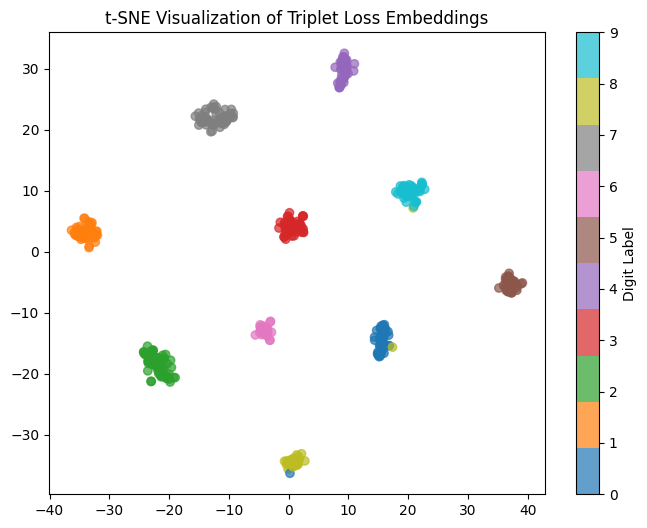

In [ ]:
visualize_triplet_embeddings(model)


## 3. Adding classification

The model we designed up to now learn to separate our classes, and t-SNE has shown us how the embeddings are correctly separated. But this is a high level representation. For task like classification we still require to map these embedding to specific classes. We can lavarage the trained feature extractor which already provide separate embeddings and add a classification head to our model to predict the different MNIST classes.

The first element to update is the model. It is similar to the one we have used up to now, but we add afinal layer, a linear layer which shrink our data from the size of the embedding to the number of classes of our dataset.

In [ ]:
class MetricCNN(nn.Module):
    def __init__(self, embedding_dim=128, num_classes=10):
        super(MetricCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.embedding_fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

        self.classifier_fc = nn.Sequential(
            nn.Linear(embedding_dim, num_classes)  # Classification head (10 classes for MNIST)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        embedding = self.embedding_fc(x)
        embedding = F.normalize(embedding, p=2, dim=1)  # L2 normalization

        class_logits = self.classifier_fc(embedding)  # Predict class logits (before softmax)
        return embedding, class_logits

We also update the training loop. Most importantly  we have now two losses, the triplet loss to learn the embeddings, and a simple cross entropy to train for classification. The model returns both embeddings and predicted class, so we can compute the two losses and combine them. This become then a multi-loss problem, but for this example we simply combine them wiht a weight of 0.5 (alpha)

In [ ]:
# Train the Siamese Network
def train_triplet(epochs=5, batch_size=64, learning_rate=0.001, alpha=0.5):
    """
    Train the model using both triplet loss (distance-based learning) and classification loss.
    `alpha` is the weight for triplet loss vs classification loss.
    """
    print("Dataset Loading")
    train_dataset = TripletMNISTDataset(train=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    print("Model Initialization")
    model = MetricCNN(embedding_dim=128, num_classes=10).to(device)
    criterion_triplet = TripletLoss(margin=1.0)
    criterion_classification = nn.CrossEntropyLoss()  # For classification head
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training Process")
    for epoch in range(epochs):
        epoch_loss = 0
        for anchor, positive, negative, labels in train_loader:
            anchor, positive, negative, labels = (
                anchor.to(device), positive.to(device), negative.to(device), labels.to(device)
            )

            # Forward pass
            anchor_emb, anchor_logits = model(anchor)
            positive_emb, _ = model(positive)
            negative_emb, _ = model(negative)

            # Compute triplet loss
            loss_triplet = criterion_triplet(anchor_emb, positive_emb, negative_emb)

            # Compute classification loss
            loss_classification = criterion_classification(anchor_logits, labels)

            # Combine both losses
            loss = alpha * loss_triplet + (1 - alpha) * loss_classification

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), "triplet_classification_mnist.pth")
    print("Model saved as triplet_classification_mnist.pth")
    return model

Finally we still visualzie the embeddings. But this time we also compute the accuracy on the classification task to get a numeric value on the result

In [ ]:
def visualize_triplet_embeddings(model, n_samples=500):
    test_dataset = TripletMNISTDataset(train=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    embeddings, true_labels, predictions = [], [], []
    model.eval()

    with torch.no_grad():
        for anchor, _, _, label in test_loader:
            anchor = anchor.to(device)
            embedding, class_logits = model(anchor)

            embeddings.append(embedding.cpu().numpy().flatten())
            true_labels.append(label.item())

            # Predict class
            predicted_class = torch.argmax(class_logits, dim=1).cpu().item()
            predictions.append(predicted_class)

            if len(embeddings) >= n_samples:
                break

    embeddings = np.array(embeddings)
    labels = np.array(true_labels)

    from sklearn.manifold import TSNE
    X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(label="Digit Label")
    plt.title("t-SNE Visualization of Triplet + Classification Model")
    plt.show()

    # Compute classification accuracy
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    print(f"Classification Accuracy: {accuracy * 100:.2f}%")

First we run the train code

In [ ]:
model = train_triplet(epochs=5)

Dataset Loading
Model Initialization
Starting Training Process
Epoch [1/5], Loss: 0.2741
Epoch [2/5], Loss: 0.0366
Epoch [3/5], Loss: 0.0207
Epoch [4/5], Loss: 0.0137
Epoch [5/5], Loss: 0.0118
Model saved as triplet_classification_mnist.pth


And now we visualize the results and the accuracy

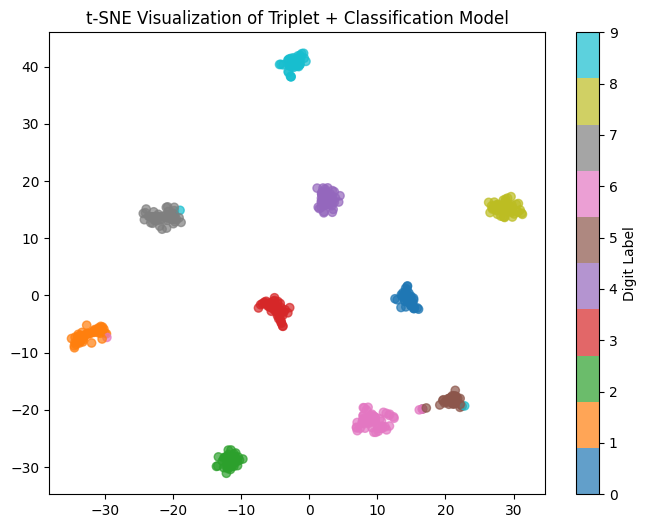

Classification Accuracy: 99.20%


In [ ]:
visualize_triplet_embeddings(model)

## 4. More interesting datasets
On MNIST everything works really well, even a couple of epochs can give decent results.

We try now on a slightly more complex dataset, CIFAR-10.
Most of the code is already written, and we don't need to change it, at least for the moment. We write the data loader to take this new data

In [ ]:
from torchvision.datasets import CIFAR10

class TripletCIFARDataset(Dataset):
    def __init__(self, train=True):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Normalize images
        ])
        self.dataset = CIFAR10(root="./data", train=train, transform=transform, download=True)
        self.data = self.dataset.data  # Now this is a numpy array
        self.targets = np.array(self.dataset.targets)  # Convert labels to numpy array

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        anchor, label = self.data[index], self.targets[index]

        # Convert to tensor (needed for selecting positive/negative)
        anchor = torch.tensor(anchor).permute(2, 0, 1).float() / 255.0  # Convert RGB

        # Select a positive sample (same class)
        positive_indices = np.where(self.targets == label)[0]
        positive_index = np.random.choice(positive_indices)
        positive = torch.tensor(self.data[positive_index]).permute(2, 0, 1).float() / 255.0

        # Select a negative sample (different class)
        negative_indices = np.where(self.targets != label)[0]
        negative_index = np.random.choice(negative_indices)
        negative = torch.tensor(self.data[negative_index]).permute(2, 0, 1).float() / 255.0

        return anchor, positive, negative, int(label)


Since we are using bigger RGB data the model will be slightly different

In [ ]:
# Define the Network
class MetricCNN(nn.Module):
    def __init__(self, embedding_dim=128):
        super(MetricCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

we have to change the trianing function to use this new dataset

In [ ]:
def train_triplet(epochs=5, batch_size=64, learning_rate=0.001):
    print("Dataset Loading")
    train_dataset = TripletCIFARDataset(train=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    print("Model Initialization")
    model = MetricCNN(embedding_dim=128).to(device)
    criterion = TripletLoss(margin=1.0)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print("Starting Training Process")
    for epoch in range(epochs):
        epoch_loss = 0
        for anchor, positive, negative, _ in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Forward pass
            anchor_emb = model(anchor)
            positive_emb = model(positive)
            negative_emb = model(negative)

            # Compute loss
            loss = criterion(anchor_emb, positive_emb, negative_emb)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

    torch.save(model.state_dict(), "triplet_mnist.pth")
    print("Model saved as triplet_mnist.pth")
    return model

And similarly we change the test to use the new dataset

In [ ]:
def visualize_triplet_embeddings(model, n_samples=500):
    test_dataset = TripletCIFARDataset(train=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    embeddings, true_labels = [], []
    model.eval()

    with torch.no_grad():
        for anchor, _, _, digit_label in test_loader:
            anchor = anchor.to(device)
            embedding = model(anchor)
            embeddings.append(embedding.cpu().numpy().flatten())
            true_labels.append(digit_label.item())
            if len(embeddings) >= n_samples:
                break

    embeddings = np.array(embeddings)
    labels = np.array(true_labels)

    from sklearn.manifold import TSNE
    X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="tab10", alpha=0.7)
    plt.colorbar(label="Digit Label")
    plt.title("t-SNE Visualization of Triplet Loss Embeddings")
    plt.show()

Now we can start the training

In [ ]:
model = train_triplet(epochs=5)

Dataset Loading


100%|██████████| 170M/170M [00:04<00:00, 35.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Model Initialization
Starting Training Process
Epoch [1/5], Loss: 0.7122
Epoch [2/5], Loss: 0.5880
Epoch [3/5], Loss: 0.5214
Epoch [4/5], Loss: 0.4677
Epoch [5/5], Loss: 0.4305
Model saved as triplet_mnist.pth


And visualize our embeddings

Files already downloaded and verified


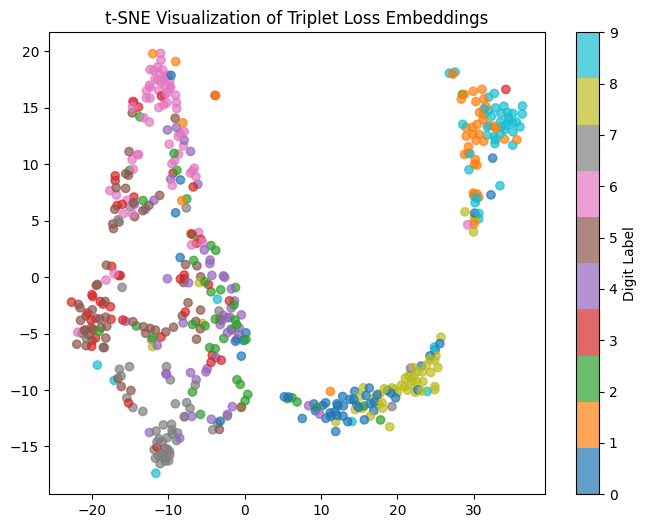

In [ ]:
visualize_triplet_embeddings(model)

The task now is more complex than MNIST, and just a few epochs can not achieve good results. Moreover, we can use additional techniques to improve the learning of the model.

In the previous example we took random elements as positive and negative examples to train the nework. Sometimes the random data will be meaningful, sometimes we will pick data which are not carrying much information, like negative which are already far away or positive which are already close.

We can improve the model to pick not a random element, but choose one from a list, and take the most informative one, negative which are still close and positive which are far. We could look for the best element that satisfy this requirement, given the whole dataset, but it is a long and inefficient process. Therefore we will pick a random set of samples for positive and negatives and pick the best one from this small set.

## 5. Unsupervised representation learning by predicting image rotations
- Simple idea, we rotate the images and learn the rotation angle
- We want a simple task, so we use only four classes for the rotation
- We use CIFAR10 and Resnet18 as dataset and models
- We use the learned embedding as pretraining for classification tasks




First we import the required libraries. Probably everything is already here, but we might have forgot someting

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.utils.data import DataLoader, Dataset
import random

Next we write the function to generate the rotations.

Eveything happens inside the getitem function, we take one element from the original dataset, we perform a rondom angle rotations, from the list of four possible angles and return the processed image and the rotation angle

In [ ]:
class RotatedDataset(Dataset):
    """
    Wraps an existing dataset (e.g., CIFAR-10) and applies a random rotation
    from [0, 90, 180, 270] degrees. The label corresponds to the rotation index.
    """
    def __init__(self, dataset):
        self.dataset = dataset
        self.angles = [0, 90, 180, 270]

    def __getitem__(self, index):
        img, _ = self.dataset[index]  # Ignore original label
        angle = random.choice(self.angles)
        rotated_img = transforms.functional.rotate(img, angle)
        label = self.angles.index(angle)
        return rotated_img, label

    def __len__(self):
        return len(self.dataset)

Since we are not building a custom model, but using a state of the art architecture it is not required to manually define all layers, we lavarage the models library to define our ResNet-18 model

In [ ]:
def get_resnet(num_classes=10):
    """
    Returns a ResNet-18 with the final fully-connected layer
    replaced by a linear layer for 'num_classes' outputs.
    """
    model = models.resnet18(pretrained=False)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

We now define a custom function to compute the accuracy of our model. This function will be run to check the accuracy on the test set at each epoch. We perform a prediction using the input dataloader, take the prediction with highest score and compare it with the ground truth

In [ ]:
def evaluate(model, dataloader, device):
    """Evaluate model accuracy on a given dataloader."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100.0 * correct / total

We now define the training function for our baseline, ResNet-18 trained on CIFAR-10 in a traditional supervised way.

We first define a set of data augmentation techniques to imporve our data. We anly use transformations which do not involve rotations, since these might not generate issues in the supervised scenario, but will certently complicate things in the self supervised. So, we use only size and color based data augmentaiton.

Next we download our train and test dataset and create the dataloaders.

Once data are ready we move on to create the model and define the loss function and the optimizer. We use cross entropy and SGD for this example. We also add a learning rate scheduler to improve the learning procedure.

Next we can finally start the training process. We iterate thorugh epochs and thorugh data. For each element we compute the loss, run the optimizer and increment the cumulative loss. For each epoch we update the accuracy. Based on the computed accuracy we only save the best performing model



In [ ]:
def train_supervised_resnet(epochs=10, batch_size=128, lr=0.01, device='cpu'):
    """
    Train a ResNet-18 in a supervised manner on CIFAR-10 classification.
    Uses a StepLR scheduler. Returns the trained model.
    """
    # Data augmentation & normalization
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

    cifar_train = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    cifar_test = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )
    train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2)

    # Build ResNet for 10-class classification
    model = get_resnet(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    # StepLR: reduce LR by gamma every step_size epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss, total, correct = 0.0, 0, 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Step the scheduler once per epoch
        scheduler.step()

        train_acc = 100.0 * correct / total
        test_acc = evaluate(model, test_loader, device)
        print(f"[Supervised] Epoch [{epoch+1}/{epochs}] "
              f"Train Acc: {train_acc:.2f}%  | Test Acc: {test_acc:.2f}%  | LR: {scheduler.get_last_lr()}")

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "best_supervised_resnet.pth")
            print(f"  -> New best supervised ResNet model saved (Acc={best_acc:.2f}%)")

    print("Finished supervised training. Best test accuracy = {:.2f}%".format(best_acc))
    return model

The code to train the rotation model is similar to the previous one. We perform the same data augmentation technique. Since we are using a different datasetm in this scenario we predict one of the four possible rotations, we use the custom dataloader we previously defined. Then the remaining of the code follows the same structure

In [ ]:
def train_rotnet_resnet(epochs=10, batch_size=128, lr=0.01, device='cpu'):
    """
    Train a ResNet-18 to predict rotations (0, 90, 180, 270) on CIFAR-10 images.
    Uses a StepLR scheduler. Returns the trained RotNet model.
    """
    # Data augmentation & normalization
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

    cifar_train = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train
    )
    cifar_test = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test
    )

    rotated_train = RotatedDataset(cifar_train)
    rotated_test = RotatedDataset(cifar_test)

    train_loader = DataLoader(rotated_train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(rotated_test, batch_size=batch_size, shuffle=False, num_workers=2)

    # Build ResNet for 4-class rotation prediction
    model = get_resnet(num_classes=4).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss, total, correct = 0.0, 0, 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        scheduler.step()

        train_acc = 100.0 * correct / total

        # Evaluate on the rotated test set
        model.eval()
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
        test_acc = 100.0 * test_correct / test_total

        print(f"[RotNet] Epoch [{epoch+1}/{epochs}] "
              f"Train Acc: {train_acc:.2f}% | Test Acc (rotation): {test_acc:.2f}% | LR: {scheduler.get_last_lr()}")

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "best_rotnet_resnet.pth")
            print(f"  -> New best RotNet ResNet model saved (Acc={best_acc:.2f}%)")

    print("Finished RotNet training. Best rotation test accuracy = {:.2f}%".format(best_acc))
    return model

Now that both supervised and rotation model are defined we can start the training procedure

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("=== Train Supervised ResNet-18 ===")
    sup_model = train_supervised_resnet(epochs=1, batch_size=128, lr=0.01, device=device)

    print("\n=== Train RotNet ResNet-18 ===")
    rot_model = train_rotnet_resnet(epochs=1, batch_size=128, lr=0.01, device=device)

if __name__ == '__main__':
    main()

=== Train Supervised ResNet-18 ===


NameError: name 'train_supervised_resnet' is not defined

Now that we have two trained model, one with standard supervised techniques and one with rotations we can evaluate how well the rotation has performed. We can use different approaches; instead of using the rotation model as a pretraining we can look at how the model is working, and compare it with the supervised version. In particular we can look at the activation functions of the first layer to see if we can see some similarity between the two models.

As usual we make sure eveything is properly included

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

We now define a visualization function to visualize the activation functions of the first layers.

Our function takes as input the model and the weights and saves the visualization to file.

The function access the weight of the first layer and perform some normalization to better show the data.Since this layer has multiple filters we shape them as a grid with eight rows

In [ ]:
def visualize_first_layer_filters(model, save_path="first_layer_filters.png"):
    """
    Visualizes the learned filters in the model's first convolutional layer
    and saves them as a single image grid.
    """
    # 1) Get the weight tensor from the first conv layer.
    conv1_weights = model.conv1.weight.data.clone()

    # 2) Normalize the weights to [0,1] for display
    min_val = conv1_weights.min()
    max_val = conv1_weights.max()
    conv1_weights = (conv1_weights - min_val) / (max_val - min_val)

    # 3) Make a grid of these filters
    #    nrow=8 => 8 filters per row (adjust as you like)
    grid = vutils.make_grid(conv1_weights, nrow=8, padding=2)

    # 4) Convert the grid to a NumPy array
    np_grid = grid.cpu().numpy().transpose((1, 2, 0))

    # 5) Plot and save
    plt.figure(figsize=(8,8))
    plt.imshow(np_grid)
    plt.title("First Convolutional Layer Filters")
    plt.axis('off')
    plt.savefig(save_path, dpi=150)
    plt.close()
    print(f"Filter visualization saved to '{save_path}'")

Now that we have defined a function to show the results we simply have to all it passing first the supervised version of the model and then the rotation version.

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Example: load a trained ResNet-18 for CIFAR-10 (10 classes)
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    # Load your checkpoint (e.g., best_supervised_resnet.pth or best_rotnet_resnet.pth)
    checkpoint_path = "/content/rotnet/best_supervised_resnet.pth"
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    # Visualize the filters
    visualize_first_layer_filters(model, save_path="images/first_layer_filters_super.png")

    # Example: load a trained ResNet-18 for CIFAR-10 (10 classes)
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 4)
    # Load your checkpoint (e.g., best_supervised_resnet.pth or best_rotnet_resnet.pth)
    checkpoint_path = "/content/rotnet/best_rotnet_resnet.pth"
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()

    # Visualize the filters
    visualize_first_layer_filters(model, save_path="/content/images/first_layer_filters_rot.png")

if __name__ == "__main__":
    main()

<ipython-input-6-e48a0163b5b6>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Filter visualization saved to 'images/first_layer_filters_super.png'


<ipython-input-6-e48a0163b5b6>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Filter visualization saved to '/content/images/first_layer_filters_rot.png'


The previous results display some similarity between the two models, but it is not so clear. Partially due to the size of the filter and the limited epochs used for training the model.

But we can use a more powerful tool to compare the two network, gradcam.
Grad-CAM (Gradient-weighted Class Activation Mapping) should show us which part of the image the model is focusing, and we should be able to notiece some similarity between the two developed models.

But, is this really a good method to comare the two models?

As usual some includes

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In this implementation of gradcam we take a model and a specific layer for which we want to compute the gradcam

Next we register two hooks to extract intermediate value from the network. The first one will be for the feature maps, the second one for the gradients

Next we define these hooks. The forward one will run when the model does the forward pass trough the target_layer previously defined. It saves the activation of that layer, giving us an hint on what our model is looking at. The next one is the backward hook, which runs during the backpropagation and saves the gradients of the target_layer. This provide us with an hint on which part of the activation map was the most important.

Once these elements are defined we run our model, compute the loss, and run the backpropagation.

We then compute the weights and use them on the retrieved activations. Finaly we apply relu to the output to remove negative values and resize the map to match the original input image. After normallization the mask is returned by the generate_cam function

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        """
        model: the neural network model.
        target_layer: the layer for which to compute GradCAM.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        # Register hooks
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        # Save the activations (feature maps)
        self.activations = output.detach()

    def backward_hook(self, module, grad_input, grad_output):
        # Save the gradients of the output
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor, target_class=None):
        """
        Computes the GradCAM heatmap.
        input_tensor: the input image tensor of shape [1, C, H, W].
        target_class: if provided, backpropagate the gradient for that class.
                      Otherwise, use the class with the highest score.
        Returns a heatmap (2D numpy array) normalized between 0 and 1.
        """
        self.model.zero_grad()
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1)
        # Assume batch size = 1.
        loss = output[0, target_class[0]]
        loss.backward(retain_graph=True)
        # Global average pooling on the gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        # Compute weighted combination of the activations
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        # Upsample to the input size
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam[0, 0].cpu().numpy()

This is just an utility function to load our two models, the resnet 18 trained in a supervised way and the one trained using rotations

In [ ]:
def load_models(device):
    """
    Loads the supervised AlexNet (for CIFAR-10 classification) and
    the RotNet AlexNet (for rotation prediction) from saved weights.
    """
    # Supervised model: 10 output classes
    sup_model = models.resnet18(pretrained=False)
    sup_model.fc = nn.Linear(sup_model.fc.in_features, 10)
    sup_model.load_state_dict(torch.load("/content/rotnet/best_supervised_resnet.pth", map_location=device))
    sup_model.to(device)
    sup_model.eval()

    # RotNet model: 4 output classes (rotation prediction)
    rot_model = models.resnet18(pretrained=False)
    rot_model.fc = nn.Linear(rot_model.fc.in_features, 4)
    rot_model.load_state_dict(torch.load("/content/rotnet/best_rotnet_resnet.pth", map_location=device))
    rot_model.to(device)
    rot_model.eval()

    return sup_model, rot_model

This is also a utility function to handle data

In [ ]:
def unnormalize(img_tensor):
    """
    Converts a normalized tensor (using mean=0.5 and std=0.5) back to a NumPy image.
    """
    img_tensor = img_tensor * 0.5 + 0.5
    img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img_np = np.clip(img_np, 0, 1)
    return img_np

Now that we have all functions defined we can run gradcam on our models.

First we select the last convolutional layer of Resnet18, layer4, and inizialize gradcam for both models on this layer.

Next we dafine the data transformation to match the proper input shape and load the dataset. We will run gradcam only on some of the many available images.

Finally we difne our image structure, with three columns for the original input and the two gradcams, and iterate trough the images. For each iamge we call the gradcam function for both model and generate the cam, which is shown next to the input imge.

If the model has been trained for enough epochs we should be able to appreciate how the gradcam results are similar for the two trained models.


<ipython-input-12-743c9905bc46>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sup_model.load_state_dict(torch.load("/content/rotnet/best_supervised_resnet.pth", map_locat

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


GradCAM comparison figure saved to 'images/gradcam_comparison.png'


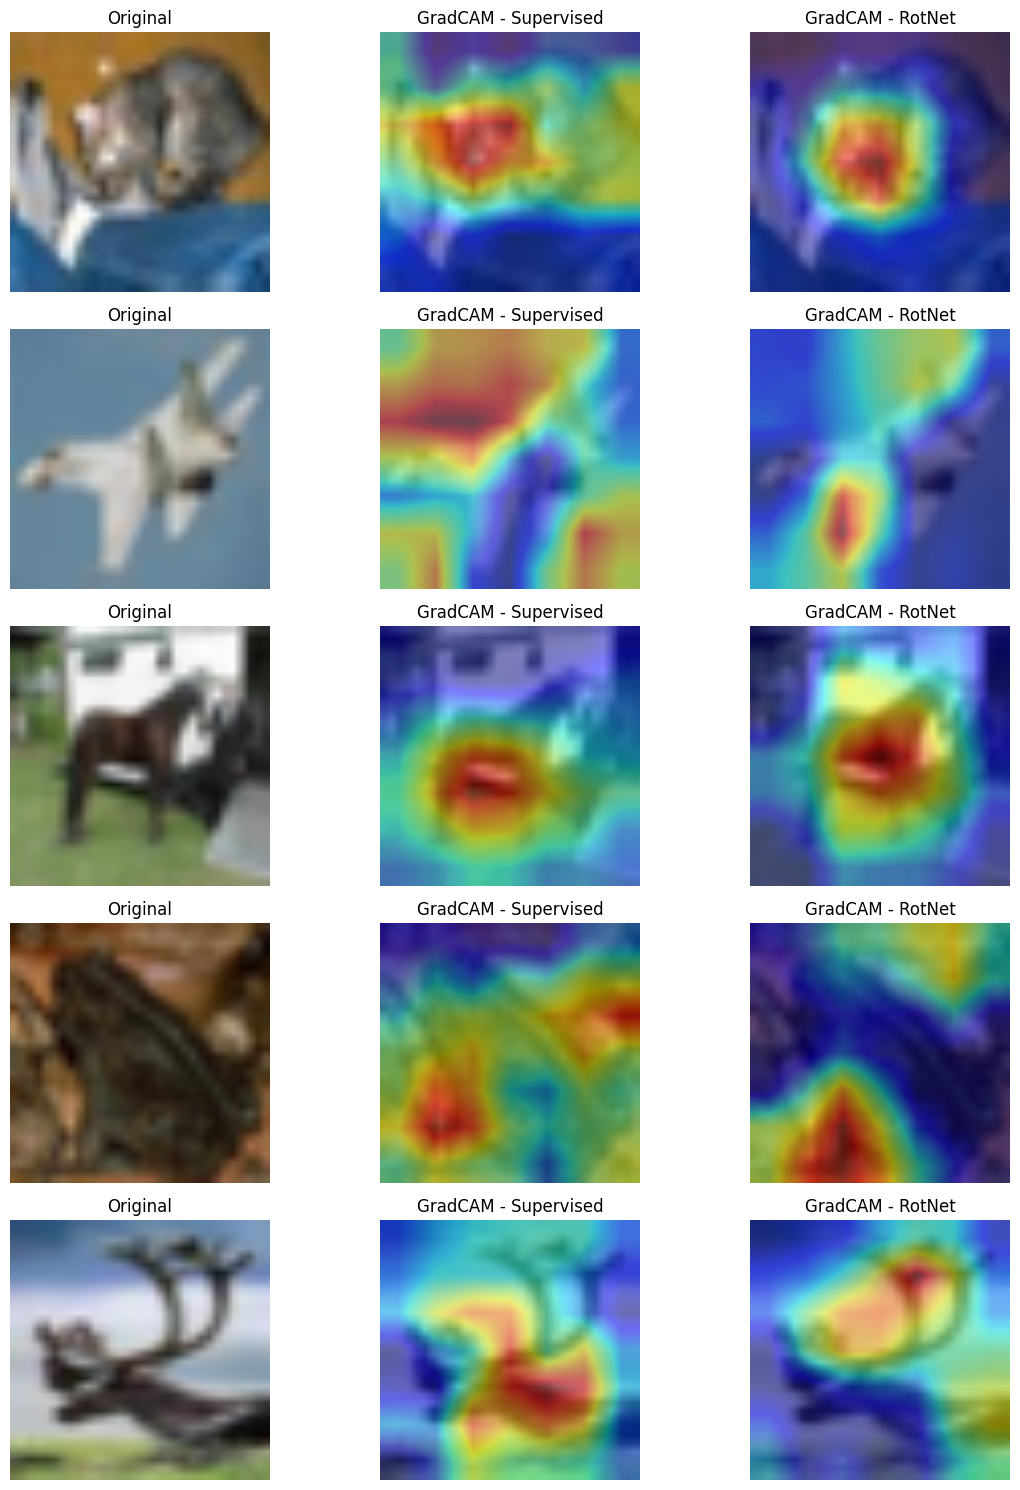

In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sup_model, rot_model = load_models(device)

    # For GradCAM we choose the last convolutional layer
    target_layer_sup = sup_model.layer4
    target_layer_rot = rot_model.layer4
    gradcam_sup = GradCAM(sup_model, target_layer_sup)
    gradcam_rot = GradCAM(rot_model, target_layer_rot)

    # Define the CIFAR-10 test transform (resize to 224x224 and normalize)
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load CIFAR-10 test set
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Choose a few test images (e.g., indices 0, 10, 20, 30, 40)
    indices = [0, 10, 20, 30, 40]
    num_images = len(indices)

    # Prepare a figure: each row shows Original, GradCAM (Supervised), GradCAM (RotNet)
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 3 * num_images))
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(indices):
        img_tensor, label = test_set[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)

        # Generate GradCAM heatmaps for both models
        cam_sup = gradcam_sup.generate_cam(input_tensor)
        cam_rot = gradcam_rot.generate_cam(input_tensor)

        # Unnormalize the image for display
        img_disp = unnormalize(img_tensor)

        # Plot original image
        axes[i, 0].imshow(img_disp)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        # Overlay GradCAM (Supervised)
        axes[i, 1].imshow(img_disp)
        axes[i, 1].imshow(cam_sup, cmap='jet', alpha=0.5)
        axes[i, 1].set_title("GradCAM - Supervised")
        axes[i, 1].axis('off')

        # Overlay GradCAM (RotNet)
        axes[i, 2].imshow(img_disp)
        axes[i, 2].imshow(cam_rot, cmap='jet', alpha=0.5)
        axes[i, 2].set_title("GradCAM - RotNet")
        axes[i, 2].axis('off')

    plt.tight_layout()
    # Save the final figure to file
    save_path = "images/gradcam_comparison.png"
    plt.savefig(save_path, dpi=150)
    print(f"GradCAM comparison figure saved to '{save_path}'")
    plt.show()

if __name__ == '__main__':
    main()

As a final test to show the advantages of this technique you could keep the trained layer using rotation and perform only fine tuning on the last layer.

In [ ]:
def get_finetuned_resnet(rot_model_path, num_classes=10, device='cpu'):
    """
    Loads a pre-trained RotNet model and modifies the last layer for classification.
    """
    model = models.resnet18(pretrained=False)  # Create ResNet-18
    in_features = model.fc.in_features  # Extract the input size of the last layer

    # Load RotNet pre-trained weights
    checkpoint = torch.load(rot_model_path, map_location=device)
    model.load_state_dict(checkpoint)

    # Replace the last layer with a new one for classification (10 classes)
    model.fc = nn.Linear(in_features, num_classes)

    return model.to(device)

Now you could run again the training loop to perform some finetuning of this model

## 6. Beyond a Gaussian denoiser: Residual learning of deep CNN for image denoising

- CNN has to learn the noise in the image, not the denoised image
- Simple architecture with 17 convolutional layer
- MSE loss
- Test on  CIFAR10

First lets make sure we have all the required includes

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import urllib.request
import tarfile

Next we load our dataset, MNIST is too simple, so we use CIFAR10. We resize it to have a dimension compatible with our network

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root="dataset", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="dataset", train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified


Next we create the custom dataset, starting from CFAR and adding noise.

For this example we use gaussian noise with standard devietion of 25 in the pixel value

Finally we create the dataloader for train and test

In [ ]:
# Custom dataset class for adding noise
class NoisyDataset(Dataset):
    def __init__(self, dataset, noise_level=25):
        self.dataset = dataset
        self.noise_level = noise_level

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        img = img.numpy().squeeze()
        noise = np.random.normal(0, self.noise_level / 255.0, img.shape).astype(np.float32)
        noisy_img = img + noise
        return torch.tensor(noisy_img).unsqueeze(0), torch.tensor(img).unsqueeze(0)

train_dataset_noisy = NoisyDataset(train_dataset)
test_dataset_noisy = NoisyDataset(test_dataset)
train_loader = DataLoader(train_dataset_noisy, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset_noisy, batch_size=8, shuffle=False)

Now we define our model. As in the original work it is a 17 layer architecture

we set channel=1 since we want to work on greyscale and features=64 for the number of filters for each layer

The first and last layer have a slightly different structure, the first one is conv+relu, and the last one is only a convolutional, while the central layers are a sequence of conv, batch normalization and relu.

It is important to notiece that the network is designed to predict the noise, so the output of the model is noise. If we want to retrieve the denoised image we have to compute the difference between the input image and the prediction, as done in the forward function

In [ ]:
# DnCNN Model (17-layer architecture as in the paper)
class DnCNN(nn.Module):
    def __init__(self, depth=17, channels=1, features=64):
        super(DnCNN, self).__init__()

        layers = [
            nn.Conv2d(channels, features, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        ]

        for _ in range(depth - 2):  # Middle layers
            layers.append(nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Conv2d(features, channels, kernel_size=3, padding=1, bias=False))  # Output layer

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Residual learning

Make sure the GPU is still there

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now we call our function and inizialize the model. We also define the loss function as a simple Means Squared Error, and we set the optimizer to Adam

In [ ]:
# Initialize model, loss, and optimizer
model = DnCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

The final step is the training loop. We set 10 epochs, which are still too much to see here live, and too few to get particularly accurate results... So it's a good compromise

We compute the loss as the MSE given the clean image and the denoised one

In [ ]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for noisy_imgs, clean_imgs in tqdm(train_loader):
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        optimizer.zero_grad()
        denoised_imgs = model(noisy_imgs)
        loss = criterion(denoised_imgs, clean_imgs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")

100%|██████████| 6250/6250 [12:41<00:00,  8.21it/s]


Epoch 1/10, Loss: 0.000800


 42%|████▏     | 2624/6250 [05:19<07:22,  8.20it/s]


KeyboardInterrupt: 

Now that we have a trained model we can proceed with the testing. We use BSD68 images for testing. We have to do some tricks to get them because there is no easy repo, but they are on github. So, the easy option would be to go on github and download them in a folder. If we want to do this within the code with have some code to downloadthe zip and uncomoress it in the proper folder.

Lets load our weights

In [ ]:
# Load the best checkpoint before evaluation
model.load_state_dict(torch.load("/content/denoise/best_checkpoint.pth"))
print("Loaded best checkpoint for evaluation.")

Loaded best checkpoint for evaluation.


<ipython-input-10-7dc055cf6a34>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/denoise/best_checkpoint.pth"))


In [ ]:
import zipfile
# Load BSD68 dataset from a working link
bsd68_url = "https://github.com/cszn/DnCNN/archive/refs/heads/master.zip"
bsd68_dir = "/content/dataset/BSD68"
os.makedirs(bsd68_dir, exist_ok=True)
bsd68_zip = os.path.join(bsd68_dir, "BSD68.zip")

if not os.path.exists(bsd68_zip):
    print("Downloading BSD68 dataset...")
    urllib.request.urlretrieve(bsd68_url, bsd68_zip)
    print("Extracting BSD68 dataset...")
    with zipfile.ZipFile(bsd68_zip, 'r') as zip_ref:
        zip_ref.extractall(bsd68_dir)

bsd68_images = [os.path.join(bsd68_dir, "DnCNN-master/testsets/BSD68", f) for f in os.listdir(os.path.join(bsd68_dir, "DnCNN-master/testsets/BSD68"))]

# Testing on multiple BSD68 images
output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)

Extracting BSD68 dataset...


We need a preprocessing function to reshape the images in away we can easily use them

In [ ]:
# Testing on BSD68
def process_image(img_path):
    img = Image.open(img_path).convert("L")
    img = img.resize((128, 128))
    img = np.array(img).astype(np.float32) / 255.0
    noisy_img = img + np.random.normal(0, 25/255.0, img.shape).astype(np.float32)
    return torch.tensor(noisy_img).unsqueeze(0).unsqueeze(0), img

And finally we iterate through the images, in our scenario just five images from the dataset.

We first generate the noisy image and process it with our trained model. Then we combine them for visualization purposes and generate a single image with the original input, the noisy one, and the denoised.

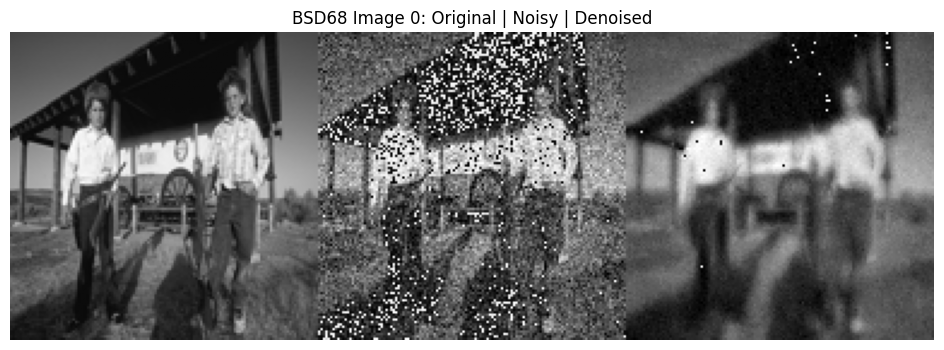

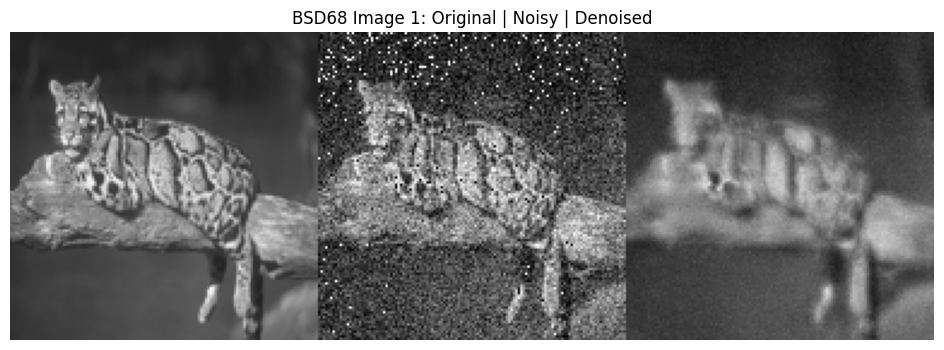

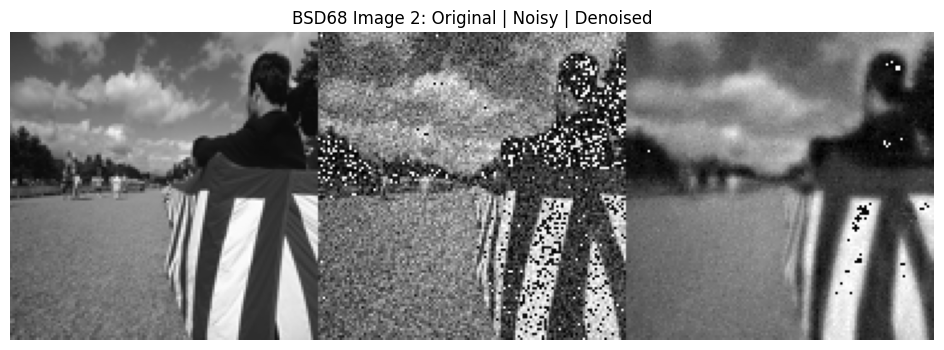

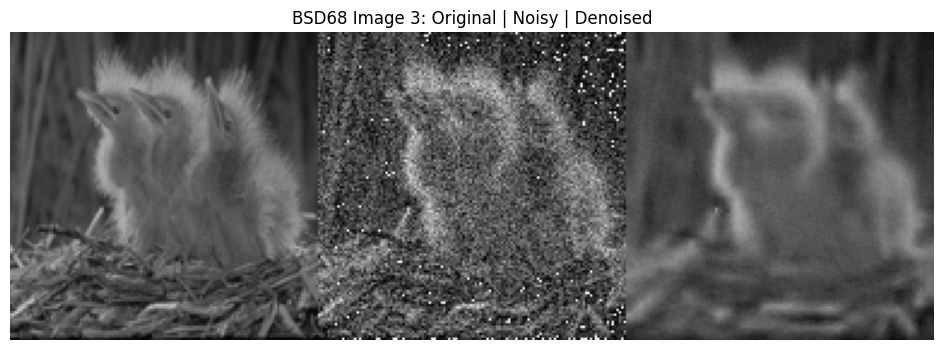

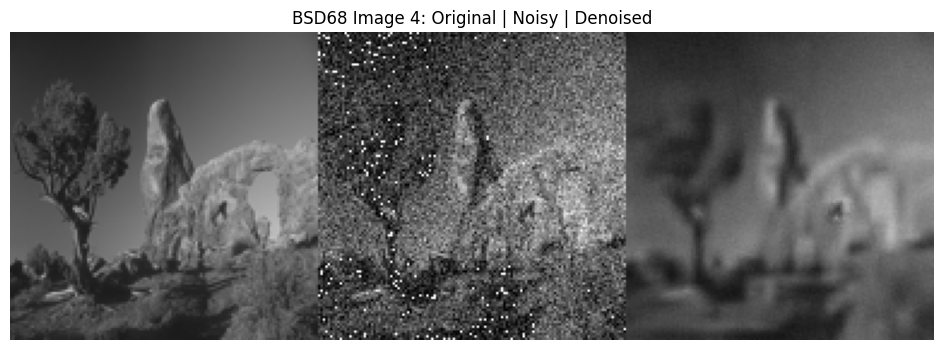

In [ ]:
for i, img_path in enumerate(bsd68_images[:5]):  # Process first 5 images
    bsd68_noisy, bsd68_clean = process_image(img_path)
    bsd68_noisy = bsd68_noisy.to(device)
    with torch.no_grad():
        bsd68_denoised = model(bsd68_noisy).squeeze().cpu().numpy()
        bsd68_noisy = bsd68_noisy.squeeze().cpu().numpy()

    combined_bsd68 = np.hstack([
        (bsd68_clean * 255).astype(np.uint8),
        (bsd68_noisy * 255).astype(np.uint8),
        (bsd68_denoised * 255).astype(np.uint8)
    ])
    Image.fromarray(combined_bsd68).save(f"{output_dir}/bsd68_comparison_{i}.png")

    # Display results
    plt.figure(figsize=(12, 4))
    plt.imshow(combined_bsd68, cmap='gray')
    plt.title(f"BSD68 Image {i}: Original | Noisy | Denoised")
    plt.axis('off')
    plt.show()

## 7. Noise2Void – Learning Denoising from Single Noisy Images

In the previous example we required couple of images to train our model; a clear image, and an image with generated noise.

We might have scenarios where we don't have clear images to work with. This model is designed to work with only a noisy image. The model is designed to predict a pixel without seeing it, learning the clean structure from the surrounding noisy data.

The model is based on a modified version of u-net

First some import

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import urllib.request
import zipfile
from PIL import Image

We add an helper function for the final steps, when we evaluate on different data

In [ ]:
def center_crop(tensor, target_tensor):
    """
    Center-crop tensor to the size of target_tensor along H and W.
    """
    _, _, h, w = target_tensor.size()
    _, _, h_t, w_t = tensor.size()
    delta_h = h_t - h
    delta_w = w_t - w
    crop_top = delta_h // 2
    crop_left = delta_w // 2
    return tensor[:, :, crop_top:crop_top+h, crop_left:crop_left+w]

We then define our model. It is a U-net like architecture, although smaller than the original version for the U-net paper. But powerfoul enough to show how the denoising works.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)                  # [B, 64, H, W]
        enc2 = self.enc2(self.pool1(enc1))     # [B, 128, H/2, W/2]
        enc3 = self.enc3(self.pool2(enc2))     # [B, 256, H/4, W/4]

        # Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))  # [B, 512, H/8, W/8]

        # Decoder path with skip connections and cropping
        dec3 = self.up3(bottleneck)                      # [B, 256, H/4, W/4]
        enc3_cropped = center_crop(enc3, dec3)
        dec3 = torch.cat((dec3, enc3_cropped), dim=1)     # Concatenate along channels
        dec3 = self.dec3(dec3)

        dec2 = self.up2(dec3)                            # [B, 128, H/2, W/2]
        enc2_cropped = center_crop(enc2, dec2)
        dec2 = torch.cat((dec2, enc2_cropped), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.up1(dec2)                            # [B, 64, H, W]
        enc1_cropped = center_crop(enc1, dec1)
        dec1 = torch.cat((dec1, enc1_cropped), dim=1)
        dec1 = self.dec1(dec1)

        out = self.final_conv(dec1)
        return out

We lavarage again the CIFAR dataset to generate our data.

We define two variables which regulates how effected our images will be by noise and how big the masking will be. In particular noise level define the strenght of the noise, the noise image is generate using this value. Then we have to mask some pixel, whose values the network has to learn based on the surrounding noisy data. The area of maskin is regulated by the mask_ration value

In [ ]:
class NoisyDataset(Dataset):
    def __init__(self, dataset, noise_level=0.2, mask_ratio=0.1):
        self.dataset = dataset
        self.noise_level = noise_level
        self.mask_ratio = mask_ratio

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        noisy = image + self.noise_level * torch.randn_like(image)
        noisy = torch.clamp(noisy, 0, 1)  # Ensure values are valid
        mask = torch.rand_like(image) < self.mask_ratio
        masked_noisy = noisy.clone()
        masked_noisy[mask] = 0  # Hide some pixels
        return masked_noisy, noisy, image

we now download our dataset, define a set of pre-processing transformations and create the dataloader for the train dataset

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])
dataset_train = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform_train)
noisy_dataset_train = NoisyDataset(dataset_train, noise_level=0.2, mask_ratio=0.1)
train_loader = DataLoader(noisy_dataset_train, batch_size=64, shuffle=True)

100%|██████████| 169M/169M [00:05<00:00, 30.6MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


We now define our model, the loss and the optimizer. We can train the model with a standard MSE loss on the pixel values. We also use a scheduled loss function

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


we can now start the training process. We predict the unmaksed image given the noisy masked image.


In [ ]:
epochs = 1
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for masked_noisy, noisy, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        masked_noisy, noisy = masked_noisy.to(device), noisy.to(device)
        optimizer.zero_grad()
        output = model(masked_noisy)
        loss = criterion(output, noisy)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    lr_scheduler.step(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1/1: 100%|██████████| 782/782 [01:16<00:00, 10.25it/s]

Epoch 1, Loss: 0.0139


Finally we test the final model. First we download the dataset for the tests, which is again BSD68

In [ ]:
bsd68_url = "https://github.com/cszn/DnCNN/archive/refs/heads/master.zip"
bsd68_dir = "dataset/BSD68"
os.makedirs(bsd68_dir, exist_ok=True)
bsd68_zip = os.path.join(bsd68_dir, "BSD68.zip")

if not os.path.exists(bsd68_zip):
    print("Downloading BSD68 dataset...")
    urllib.request.urlretrieve(bsd68_url, bsd68_zip)
    print("Extracting BSD68 dataset...")
    with zipfile.ZipFile(bsd68_zip, 'r') as zip_ref:
        zip_ref.extractall(bsd68_dir)

bsd68_folder = os.path.join(bsd68_dir, "DnCNN-master", "testsets", "BSD68")
bsd68_images = [os.path.join(bsd68_folder, f) for f in os.listdir(bsd68_folder) if f.endswith(('.png', '.jpg', '.bmp'))]

Then we define the dataset class, this time we add noise but we don't haveto add masking

In [ ]:
class BSDS68Dataset(Dataset):
    def __init__(self, image_paths, noise_level=0.2, transform=None):
        self.image_paths = image_paths
        self.noise_level = noise_level
        self.transform = transform if transform is not None else transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        # Add noise (without masking)
        noisy = image + self.noise_level * torch.randn_like(image)
        noisy = torch.clamp(noisy, 0, 1)
        return noisy, image

bsd68_dataset = BSDS68Dataset(bsd68_images, noise_level=0.2, transform=transforms.ToTensor())
test_loader = DataLoader(bsd68_dataset, batch_size=1, shuffle=False)

Finally we run our model on the generated noisy images, and show the output

In [ ]:
output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)
model.eval()
with torch.no_grad():
    for i, (noisy, original) in enumerate(test_loader):
        noisy, original = noisy.to(device), original.to(device)
        output = model(noisy).cpu().squeeze(0)
        noisy = noisy.cpu().squeeze(0)
        original = original.cpu().squeeze(0)

        # Plot original, noisy, and denoised images side by side
        fig, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(original.permute(1, 2, 0))
        ax[0].set_title("Original")
        ax[0].axis("off")

        ax[1].imshow(noisy.permute(1, 2, 0))
        ax[1].set_title("Noisy")
        ax[1].axis("off")

        ax[2].imshow(output.permute(1, 2, 0))
        ax[2].set_title("Denoised")
        ax[2].axis("off")

        plt.savefig(os.path.join(output_dir, f"BSD68_result_{i}.png"))
        plt.close()
        print(f"Saved {os.path.join(output_dir, f'BSD68_result_{i}.png')}")

print("Training complete! BSD68 test results saved in 'output_images' folder.")

Saved output_images/BSD68_result_0.png


Saved output_images/BSD68_result_1.png


Saved output_images/BSD68_result_2.png


Saved output_images/BSD68_result_3.png


Saved output_images/BSD68_result_4.png


Saved output_images/BSD68_result_5.png


Saved output_images/BSD68_result_6.png


Saved output_images/BSD68_result_7.png


Saved output_images/BSD68_result_8.png


Saved output_images/BSD68_result_9.png
Saved output_images/BSD68_result_10.png


Saved output_images/BSD68_result_11.png


Saved output_images/BSD68_result_12.png


Saved output_images/BSD68_result_13.png


Saved output_images/BSD68_result_14.png


Saved output_images/BSD68_result_15.png


Saved output_images/BSD68_result_16.png


Saved output_images/BSD68_result_17.png


Saved output_images/BSD68_result_18.png


Saved output_images/BSD68_result_19.png


Saved output_images/BSD68_result_20.png


Saved output_images/BSD68_result_21.png


Saved output_images/BSD68_result_22.png


Saved output_images/BSD68_result_23.png


Saved output_images/BSD68_result_24.png


Saved output_images/BSD68_result_25.png


Saved output_images/BSD68_result_26.png


Saved output_images/BSD68_result_27.png


Saved output_images/BSD68_result_28.png


Saved output_images/BSD68_result_29.png


Saved output_images/BSD68_result_30.png


Saved output_images/BSD68_result_31.png


Saved output_images/BSD68_result_32.png


Saved output_images/BSD68_result_33.png


Saved output_images/BSD68_result_34.png


Saved output_images/BSD68_result_35.png


Saved output_images/BSD68_result_36.png


Saved output_images/BSD68_result_37.png


Saved output_images/BSD68_result_38.png


Saved output_images/BSD68_result_39.png


Saved output_images/BSD68_result_40.png


Saved output_images/BSD68_result_41.png


Saved output_images/BSD68_result_42.png


Saved output_images/BSD68_result_43.png


Saved output_images/BSD68_result_44.png


Saved output_images/BSD68_result_45.png


Saved output_images/BSD68_result_46.png


Saved output_images/BSD68_result_47.png


Saved output_images/BSD68_result_48.png
Saved output_images/BSD68_result_49.png


Saved output_images/BSD68_result_50.png


Saved output_images/BSD68_result_51.png


Saved output_images/BSD68_result_52.png


Saved output_images/BSD68_result_53.png


Saved output_images/BSD68_result_54.png


Saved output_images/BSD68_result_55.png


Saved output_images/BSD68_result_56.png


Saved output_images/BSD68_result_57.png


Saved output_images/BSD68_result_58.png


Saved output_images/BSD68_result_59.png


Saved output_images/BSD68_result_60.png


Saved output_images/BSD68_result_61.png


Saved output_images/BSD68_result_62.png


Saved output_images/BSD68_result_63.png


Saved output_images/BSD68_result_64.png


Saved output_images/BSD68_result_65.png


Saved output_images/BSD68_result_66.png
Saved output_images/BSD68_result_67.png
Training complete! BSD68 test results saved in 'output_images' folder.
